# Statistical Threshold Calibration for AI Assistant Outputs

This notebook implements a **statistical quality gate** for LLM outputs by:

1. **Temperature Sweep**: Generate outputs across temperatures 0.0 to 1.0 (50 outputs per temperature)
2. **Embedding**: All outputs using text-embedding-3-small
3. **Calibrating**: A threshold using KDE and bootstrap confidence intervals
4. **Temperature Analysis**: Compare output consistency across temperature levels
5. **Runtime evaluation**: Accept/retry/escalate logic
6. **Drift detection**: For ongoing monitoring

**Data Storage:**
- SQLite database (`data/calibration.db`) for persistent experiment storage
- Each experiment stores outputs with their generation parameters (model, temperature)

**Models Used:**
- `gpt-4o-mini` - Cost-effective generation with good quality
- `text-embedding-3-small` - Efficient embeddings for similarity computation

In [8]:
# Core imports
import os
import json
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import gaussian_kde, ks_2samp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

from openai import OpenAI

from scipy.stats import norm, ttest_1samp
from tqdm.auto import tqdm
import time
# Initialize OpenAI client
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

print("OpenAI client initialized successfully!")
print(f"Using models: gpt-4o-mini (generation), text-embedding-3-small (embeddings)")

OpenAI client initialized successfully!
Using models: gpt-4o-mini (generation), text-embedding-3-small (embeddings)


In [2]:
# =============================================================================
# DATABASE HELPER FUNCTIONS
# =============================================================================
import sqlite3
from pathlib import Path
from datetime import datetime
from contextlib import contextmanager

# Database path
DB_PATH = Path("../data/calibration.db")
DB_PATH.parent.mkdir(exist_ok=True)

@contextmanager
def get_db_connection():
    """Context manager for database connections."""
    conn = sqlite3.connect(DB_PATH)
    conn.row_factory = sqlite3.Row
    try:
        yield conn
    finally:
        conn.close()

def init_db():
    """Initialize the database with required tables."""
    with get_db_connection() as conn:
        cursor = conn.cursor()
        
        # Create experiments table
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS experiments (
                id INTEGER PRIMARY KEY,
                name TEXT NOT NULL,
                system_prompt TEXT NOT NULL,
                user_prompt TEXT NOT NULL,
                generation_model TEXT NOT NULL,
                description TEXT,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
        """)
        
        # Create generations table
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS generations (
                id INTEGER PRIMARY KEY,
                experiment_id INTEGER NOT NULL,
                temperature REAL NOT NULL,
                output_text TEXT NOT NULL,
                output_length INTEGER,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                FOREIGN KEY (experiment_id) REFERENCES experiments(id)
            )
        """)
        
        # Create index for fast temperature queries
        cursor.execute("""
            CREATE INDEX IF NOT EXISTS idx_generations_temp 
            ON generations(experiment_id, temperature)
        """)
        
        conn.commit()
    print("Database initialized successfully!")

def create_experiment(name: str, system_prompt: str, user_prompt: str, 
                      generation_model: str, description: str = None) -> int:
    """Create a new experiment and return its ID."""
    with get_db_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("""
            INSERT INTO experiments (name, system_prompt, user_prompt, generation_model, description)
            VALUES (?, ?, ?, ?, ?)
        """, (name, system_prompt.strip(), user_prompt.strip(), generation_model, description))
        conn.commit()
        return cursor.lastrowid

def save_generations(experiment_id: int, temperature: float, outputs: list[str]):
    """Save a batch of generated outputs to the database."""
    with get_db_connection() as conn:
        cursor = conn.cursor()
        data = [(experiment_id, temperature, output, len(output)) for output in outputs]
        cursor.executemany("""
            INSERT INTO generations (experiment_id, temperature, output_text, output_length)
            VALUES (?, ?, ?, ?)
        """, data)
        conn.commit()
    print(f"Saved {len(outputs)} outputs for temperature={temperature}")

def get_experiments() -> list[dict]:
    """Get all experiments with their generation counts."""
    with get_db_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("""
            SELECT e.*, 
                   COUNT(g.id) as generation_count,
                   COUNT(DISTINCT g.temperature) as temperature_count
            FROM experiments e
            LEFT JOIN generations g ON e.id = g.experiment_id
            GROUP BY e.id
            ORDER BY e.created_at DESC
        """)
        return [dict(row) for row in cursor.fetchall()]

def get_generations(experiment_id: int, temperature: float = None) -> list[str]:
    """Get outputs for an experiment, optionally filtered by temperature."""
    with get_db_connection() as conn:
        cursor = conn.cursor()
        if temperature is not None:
            cursor.execute("""
                SELECT output_text FROM generations 
                WHERE experiment_id = ? AND temperature = ?
                ORDER BY id
            """, (experiment_id, temperature))
        else:
            cursor.execute("""
                SELECT output_text FROM generations 
                WHERE experiment_id = ?
                ORDER BY temperature, id
            """, (experiment_id,))
        return [row['output_text'] for row in cursor.fetchall()]

def get_temperatures(experiment_id: int) -> list[float]:
    """Get all unique temperatures for an experiment."""
    with get_db_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("""
            SELECT DISTINCT temperature FROM generations 
            WHERE experiment_id = ?
            ORDER BY temperature
        """, (experiment_id,))
        return [row['temperature'] for row in cursor.fetchall()]

def get_generations_by_temperature(experiment_id: int) -> dict[float, list[str]]:
    """Get outputs grouped by temperature."""
    with get_db_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("""
            SELECT temperature, output_text FROM generations 
            WHERE experiment_id = ?
            ORDER BY temperature, id
        """, (experiment_id,))
        
        result = {}
        for row in cursor.fetchall():
            temp = row['temperature']
            if temp not in result:
                result[temp] = []
            result[temp].append(row['output_text'])
        return result

# Initialize database
init_db()

Database initialized successfully!


## Configuration Constants

Define the key parameters for our calibration experiment.

In [3]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Temperature sweep configuration
TEMPERATURES = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
OUTPUTS_PER_TEMP = 50  # Number of outputs to generate per temperature level

# Default temperature for single-output generation (used in testing/runtime)
TEMPERATURE = 0.2

# Model configurations
GENERATION_MODEL = "gpt-4o-mini"
EMBEDDING_MODEL = "text-embedding-3-small"

# Calibration parameters
THRESHOLD_PERCENTILE = 5  # Use 5th percentile as threshold (95% of good outputs above)
BOOTSTRAP_ITERATIONS = 100000  # Number of bootstrap resamples for CI
CONFIDENCE_LEVEL = 0.95  # 95% confidence interval

# Drift detection parameters
DRIFT_WINDOW_SIZE = 50  # Rolling window for drift monitoring
DRIFT_ALPHA = 0.05  # Significance level for KS test
DRIFT_Z_THRESHOLD = 2  # Z-score threshold for mean shift detection

print(f"Configuration loaded:")
print(f"  - Temperature sweep: {TEMPERATURES}")
print(f"  - Outputs per temperature: {OUTPUTS_PER_TEMP}")
print(f"  - Total outputs per experiment: {len(TEMPERATURES) * OUTPUTS_PER_TEMP}")
print(f"  - Default temperature: {TEMPERATURE}")
print(f"  - Threshold percentile: {THRESHOLD_PERCENTILE}th")
print(f"  - Bootstrap iterations: {BOOTSTRAP_ITERATIONS}")
print(f"  - Drift window size: {DRIFT_WINDOW_SIZE}")

Configuration loaded:
  - Temperature sweep: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  - Outputs per temperature: 50
  - Total outputs per experiment: 550
  - Default temperature: 0.2
  - Threshold percentile: 5th
  - Bootstrap iterations: 100000
  - Drift window size: 50


## Prompt Definitions

Define the system prompt (simulating your professional tone) and user prompt for the calibration task.

In [4]:
# =============================================================================
# PROMPT DEFINITIONS
# =============================================================================

# System prompt - Simulates professional AI architect tone
SYSTEM_PROMPT = """
You are an AI assistant that answers like a senior AI architect.

Style guidelines:
- Structured and organized responses
- Use bullet points for clarity
- Be precise and technical
- Minimal fluff - get to the point
- Actionable recommendations
- Professional tone throughout
"""

# User prompt - The question we'll generate multiple responses for
USER_PROMPT = """
Explain how to implement a threshold-based evaluation system to validate
LLM outputs using embeddings and cosine similarity.

Provide:
1. Key steps in the implementation
2. Best practices to consider
3. Potential pitfalls to avoid
"""

print("System Prompt:")
print("-" * 50)
print(SYSTEM_PROMPT.strip())
print()
print("User Prompt:")
print("-" * 50)
print(USER_PROMPT.strip())

System Prompt:
--------------------------------------------------
You are an AI assistant that answers like a senior AI architect.

Style guidelines:
- Structured and organized responses
- Use bullet points for clarity
- Be precise and technical
- Minimal fluff - get to the point
- Actionable recommendations
- Professional tone throughout

User Prompt:
--------------------------------------------------
Explain how to implement a threshold-based evaluation system to validate
LLM outputs using embeddings and cosine similarity.

Provide:
1. Key steps in the implementation
2. Best practices to consider
3. Potential pitfalls to avoid


## Generation Functions

Helper functions to generate outputs using GPT-4o-mini.

In [5]:
def generate_output(system_prompt: str, user_prompt: str, temp: float = 0.9) -> str:
    """
    Generate a single output using GPT-4o-mini.
    
    Args:
        system_prompt: The system prompt defining assistant behavior
        user_prompt: The user's question/request
        temp: Temperature for sampling (higher = more diverse)
    
    Returns:
        Generated text response
    """
    response = client.chat.completions.create(
        model=GENERATION_MODEL,
        temperature=temp,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )
    return response.choices[0].message.content


def generate_batch_outputs(system_prompt: str, user_prompt: str, n: int, temp: float = 0.9) -> list[str]:
    """
    Generate N outputs for the same prompt with progress tracking.
    
    Args:
        system_prompt: The system prompt defining assistant behavior
        user_prompt: The user's question/request
        n: Number of outputs to generate
        temp: Temperature for sampling
    
    Returns:
        List of generated text responses
    """
    outputs = []
    for _ in tqdm(range(n), desc="Generating outputs"):
        output = generate_output(system_prompt, user_prompt, temp)
        outputs.append(output)
    return outputs


# Test the generation function
print("Testing generation function...")
test_output = generate_output(SYSTEM_PROMPT, USER_PROMPT, TEMPERATURE)
print(f"Test output length: {len(test_output)} characters")
print(f"First 200 characters: {test_output[:200]}...")

Testing generation function...
Test output length: 3185 characters
First 200 characters: ### Implementation of a Threshold-Based Evaluation System for LLM Outputs Using Embeddings and Cosine Similarity

#### 1. Key Steps in the Implementation

- **Data Preparation**
  - Collect a dataset ...


## Embedding Functions

Helper functions to embed texts using text-embedding-3-small.

In [6]:
def embed_texts(texts: list[str]) -> np.ndarray:
    """
    Embed a list of texts using text-embedding-3-small.
    
    Args:
        texts: List of text strings to embed
    
    Returns:
        numpy array of shape (n_texts, embedding_dim)
    """
    response = client.embeddings.create(
        model=EMBEDDING_MODEL,
        input=texts
    )
    return np.array([d.embedding for d in response.data])


def compute_centroid(embeddings: np.ndarray) -> np.ndarray:
    """
    Compute the centroid (mean) of a set of embeddings.
    
    Args:
        embeddings: numpy array of shape (n, dim)
    
    Returns:
        Centroid vector of shape (dim,)
    """
    return embeddings.mean(axis=0)


# Test the embedding function
print("Testing embedding function...")
test_embeddings = embed_texts([test_output])
print(f"Embedding shape: {test_embeddings.shape}")
print(f"Embedding dimension: {test_embeddings.shape[1]}")

Testing embedding function...
Embedding shape: (1, 1536)
Embedding dimension: 1536


## Step 1: Experiment Selection

Select an existing experiment from the database or create a new one for the temperature sweep.

In [10]:
# =============================================================================
# EXPERIMENT SELECTION / CREATION
# =============================================================================

# Check for existing experiments
experiments = get_experiments()

EXPERIMENT_ID = None
CREATE_NEW = False

if experiments:
    print("Existing experiments in database:")
    print("=" * 80)
    for i, exp in enumerate(experiments, 1):
        temps = exp['temperature_count']
        gens = exp['generation_count']
        print(f"  [{i}] ID={exp['id']}: {exp['name']}")
        print(f"      Model: {exp['generation_model']}, Generations: {gens}, Temperatures: {temps}")
        print(f"      Created: {exp['created_at']}")
    print("=" * 80)
    print("  [0] Create new experiment")
    print()
    
    choice = input("Enter your choice (number): ").strip()
    
    if choice.isdigit() and 1 <= int(choice) <= len(experiments):
        EXPERIMENT_ID = experiments[int(choice) - 1]['id']
        print(f"\nSelected experiment ID: {EXPERIMENT_ID}")
    elif choice == '0':
        CREATE_NEW = True
    else:
        print("Invalid choice. Creating new experiment.")
        CREATE_NEW = True
else:
    print("No existing experiments found. Will create a new one.")
    CREATE_NEW = True

# Create new experiment if needed
if CREATE_NEW:
    experiment_name = input("Enter experiment name (or press Enter for auto-generated): ").strip()
    if not experiment_name:
        experiment_name = f"temp_sweep_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    EXPERIMENT_ID = create_experiment(
        name=experiment_name,
        system_prompt=SYSTEM_PROMPT,
        user_prompt=USER_PROMPT,
        generation_model=GENERATION_MODEL,
        description=f"Temperature sweep from {min(TEMPERATURES)} to {max(TEMPERATURES)}"
    )
    print(f"\nCreated new experiment: ID={EXPERIMENT_ID}, Name='{experiment_name}'")
    GENERATE_NEW = True
else:
    # Check if experiment already has generations
    existing_temps = get_temperatures(EXPERIMENT_ID)
    if existing_temps:
        print(f"\nExperiment already has data for temperatures: {existing_temps}")
        GENERATE_NEW = False
    else:
        print(f"\nExperiment has no generations yet. Will generate new outputs.")
        GENERATE_NEW = True

print(f"\nExperiment ID: {EXPERIMENT_ID}")
print(f"Generate new outputs: {GENERATE_NEW}")

No existing experiments found. Will create a new one.

Created new experiment: ID=1, Name='test1'

Experiment ID: 1
Generate new outputs: True


## Step 1b: Temperature Sweep Generation

Generate outputs across all temperature levels (0.0 to 1.0 in steps of 0.1).

**Note:** This step is skipped if the experiment already has generations.

In [11]:
# =============================================================================
# TEMPERATURE SWEEP GENERATION
# =============================================================================
# Variables EXPERIMENT_ID, GENERATE_NEW defined in Cell 12 (Experiment Selection)

if not GENERATE_NEW:
    print("Skipping generation - experiment already has data.")
    print(f"Use the next cell to load outputs from the database.")
else:
    print(f"Starting temperature sweep generation...")
    print(f"  Temperatures: {TEMPERATURES}")
    print(f"  Outputs per temperature: {OUTPUTS_PER_TEMP}")
    print(f"  Total outputs to generate: {len(TEMPERATURES) * OUTPUTS_PER_TEMP}")
    print()
      
    total_generated = 0
    total_temps = len(TEMPERATURES)
    sweep_start = time.time()
    
    # Create progress bar for temperatures
    pbar = tqdm(TEMPERATURES, desc="Temperature sweep", unit="temp")
    
    for temp in pbar:
        step_start = time.time()
        pbar.set_description(f"Temp={temp}")
        
        # Generate outputs at this temperature
        batch_outputs = generate_batch_outputs(
            SYSTEM_PROMPT, USER_PROMPT, 
            n=OUTPUTS_PER_TEMP, 
            temp=temp
        )
        
        # Save to database
        save_generations(EXPERIMENT_ID, temp, batch_outputs)
        total_generated += len(batch_outputs)
        
        # Update progress bar with step info
        step_elapsed = time.time() - step_start
        avg_len = np.mean([len(o) for o in batch_outputs])
        pbar.set_postfix({
            'step_time': f'{step_elapsed:.1f}s',
            'avg_len': f'{avg_len:.0f}',
            'outputs': total_generated
        })
    
    total_elapsed = time.time() - sweep_start
    print(f"\n{'='*60}")
    print(f"GENERATION COMPLETE!")
    print(f"{'='*60}")
    print(f"  Total outputs generated: {total_generated}")
    print(f"  Total time: {total_elapsed/60:.1f} min ({total_elapsed:.0f}s)")
    print(f"  Average time per temperature: {total_elapsed/total_temps:.1f}s")
    print(f"  Experiment ID: {EXPERIMENT_ID}")
    print(f"  Database: {DB_PATH}")

Starting temperature sweep generation...
  Temperatures: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  Outputs per temperature: 50
  Total outputs to generate: 550



Temperature sweep:   0%|          | 0/11 [00:00<?, ?temp/s]

Generating outputs:   0%|          | 0/50 [00:00<?, ?it/s]

Saved 50 outputs for temperature=0


Generating outputs:   0%|          | 0/50 [00:00<?, ?it/s]

Saved 50 outputs for temperature=0.1


Generating outputs:   0%|          | 0/50 [00:00<?, ?it/s]

Saved 50 outputs for temperature=0.2


Generating outputs:   0%|          | 0/50 [00:00<?, ?it/s]

Saved 50 outputs for temperature=0.3


Generating outputs:   0%|          | 0/50 [00:00<?, ?it/s]

Saved 50 outputs for temperature=0.4


Generating outputs:   0%|          | 0/50 [00:00<?, ?it/s]

Saved 50 outputs for temperature=0.5


Generating outputs:   0%|          | 0/50 [00:00<?, ?it/s]

Saved 50 outputs for temperature=0.6


Generating outputs:   0%|          | 0/50 [00:00<?, ?it/s]

Saved 50 outputs for temperature=0.7


Generating outputs:   0%|          | 0/50 [00:00<?, ?it/s]

Saved 50 outputs for temperature=0.8


Generating outputs:   0%|          | 0/50 [00:00<?, ?it/s]

Saved 50 outputs for temperature=0.9


Generating outputs:   0%|          | 0/50 [00:00<?, ?it/s]

Saved 50 outputs for temperature=1.0

GENERATION COMPLETE!
  Total outputs generated: 550
  Total time: 127.2 min (7631s)
  Average time per temperature: 693.8s
  Experiment ID: 1
  Database: ..\data\calibration.db


## Step 1c: Load Data from Database

Load outputs from the database, optionally filtering by temperature for analysis.

In [12]:
# =============================================================================
# LOAD DATA FROM DATABASE
# =============================================================================

# Get available temperatures for this experiment
available_temps = get_temperatures(EXPERIMENT_ID)
print(f"Available temperatures in experiment {EXPERIMENT_ID}: {available_temps}")

# Option to select specific temperature(s) or all
print("\nSelect temperature(s) to analyze:")
print("  [A] All temperatures (for temperature comparison analysis)")
print("  [S] Single temperature (for threshold calibration)")

temp_choice = input("Enter your choice (A/S): ").strip().upper()

if temp_choice == 'S':
    print(f"\nAvailable temperatures: {available_temps}")
    selected_temp = float(input("Enter temperature value: ").strip())
    
    if selected_temp not in available_temps:
        print(f"Warning: Temperature {selected_temp} not found. Using closest available.")
        selected_temp = min(available_temps, key=lambda x: abs(x - selected_temp))
    
    # Load outputs for single temperature
    outputs = get_generations(EXPERIMENT_ID, temperature=selected_temp)
    SELECTED_TEMPERATURE = selected_temp
    MULTI_TEMP_MODE = False
    
    print(f"\nLoaded {len(outputs)} outputs for temperature={selected_temp}")
else:
    # Load all outputs grouped by temperature
    outputs_by_temp = get_generations_by_temperature(EXPERIMENT_ID)
    
    # For compatibility with downstream cells, also create flat outputs list
    # using all outputs or a default temperature
    default_temp = 0.2 if 0.2 in available_temps else available_temps[len(available_temps)//2]
    outputs = outputs_by_temp.get(default_temp, list(outputs_by_temp.values())[0])
    
    SELECTED_TEMPERATURE = default_temp
    MULTI_TEMP_MODE = True
    
    print(f"\nLoaded outputs for {len(outputs_by_temp)} temperatures:")
    for temp, temp_outputs in sorted(outputs_by_temp.items()):
        print(f"  Temperature {temp}: {len(temp_outputs)} outputs")
    print(f"\nDefault temperature for calibration: {default_temp}")

print(f"\nActive outputs for analysis: {len(outputs)}")
print(f"Average output length: {np.mean([len(o) for o in outputs]):.0f} characters")

Available temperatures in experiment 1: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

Select temperature(s) to analyze:
  [A] All temperatures (for temperature comparison analysis)
  [S] Single temperature (for threshold calibration)

Available temperatures: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

Loaded 50 outputs for temperature=0.5

Active outputs for analysis: 50
Average output length: 3186 characters


## Step 2: Create Reference and Compute Embeddings

Select a reference output and embed all outputs for similarity computation.

In [15]:
# Select reference output (first output as baseline)
# In production, you might use a human-curated "gold" reference
reference_output = outputs[0]

print("Reference output (first 500 chars):")
print("-" * 50)
print(reference_output[:500] + "...")
print()

# Embed all outputs
print("Embedding all outputs...")
embeddings = embed_texts(outputs)
print(f"Embeddings shape: {embeddings.shape}")

# Create meshgrid to represent Cartesian product of all embedding indices
n_outputs = len(embeddings)
idx_x, idx_y = np.meshgrid(np.arange(n_outputs), np.arange(n_outputs))

# Compute pairwise similarities efficiently using sklearn
# This is equivalent to computing sim(emb[i], emb[j]) for all (i,j) pairs from meshgrid
# Entry (i,j) = cosine similarity between embedding i and embedding j
pairwise_sims = cosine_similarity(embeddings)

# Compute centroid embedding (for self-consistency metric)
centroid = compute_centroid(embeddings)

# Store ALL calibration embeddings as reference for runtime evaluation
# New outputs will be compared against the entire calibration set
calibration_embeddings = embeddings  # Shape: (n_outputs, 1536)

print(f"Pairwise similarity matrix shape: {pairwise_sims.shape}")
print(f"Centroid embedding shape: {centroid.shape}")
print(f"Calibration embeddings shape: {calibration_embeddings.shape}")
print(f"Total pairwise comparisons: {n_outputs}x{n_outputs} = {n_outputs**2}")

Reference output (first 500 chars):
--------------------------------------------------
### Implementation of a Threshold-Based Evaluation System for LLM Outputs Using Embeddings and Cosine Similarity

#### 1. Key Steps in the Implementation

- **Data Preparation:**
  - Collect a dataset of reference outputs (ground truth) relevant to the tasks the LLM will perform.
  - Ensure that the dataset is diverse and representative of the expected output types.

- **Embedding Generation:**
  - Use a pre-trained model (e.g., Sentence-BERT, Universal Sentence Encoder) to generate embeddings f...

Embedding all outputs...
Embeddings shape: (50, 1536)
Pairwise similarity matrix shape: (50, 50)
Centroid embedding shape: (1536,)
Calibration embeddings shape: (50, 1536)
Total pairwise comparisons: 50x50 = 2500


## Step 3: Compute Similarity Scores

Calculate cosine similarities to reference and centroid for all outputs.

In [16]:
# Extract ALL pairwise similarities (excluding diagonal/self-similarity)
# This gives us the full distribution of how similar outputs are to each other
mask = ~np.eye(n_outputs, dtype=bool)  # Mask to exclude diagonal
sims_to_ref = pairwise_sims[mask]  # Shape: (n_outputs * (n_outputs-1),) = (9900,)

# Compute similarity to centroid (self-consistency metric)
sims_to_centroid = cosine_similarity(embeddings, centroid.reshape(1, -1)).flatten()

print("Pairwise Similarities (All Pairs, excluding self):")
print(f"  Total pairs: {len(sims_to_ref)}")
print(f"  Mean: {np.mean(sims_to_ref):.4f}")
print(f"  Std:  {np.std(sims_to_ref):.4f}")
print(f"  Min:  {np.min(sims_to_ref):.4f}")
print(f"  Max:  {np.max(sims_to_ref):.4f}")
print()
print("Similarity to Centroid:")
print(f"  Mean: {np.mean(sims_to_centroid):.4f}")
print(f"  Std:  {np.std(sims_to_centroid):.4f}")
print(f"  Min:  {np.min(sims_to_centroid):.4f}")
print(f"  Max:  {np.max(sims_to_centroid):.4f}")

Pairwise Similarities (All Pairs, excluding self):
  Total pairs: 2450
  Mean: 0.9703
  Std:  0.0076
  Min:  0.9350
  Max:  0.9878

Similarity to Centroid:
  Mean: 0.9854
  Std:  0.0042
  Min:  0.9617
  Max:  0.9906


## Step 4: Visualize Similarity Distributions

Examine the distribution of similarities to understand the output consistency.

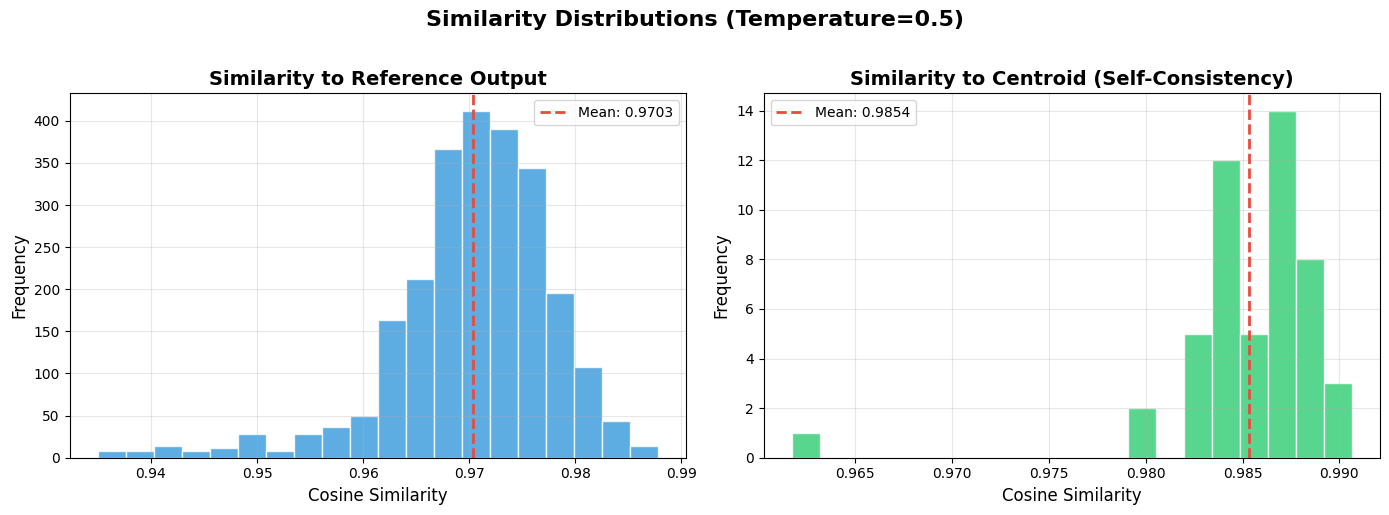

In [17]:
# Create side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Add main title with temperature
fig.suptitle(f'Similarity Distributions (Temperature={SELECTED_TEMPERATURE})', fontsize=16, fontweight='bold', y=1.02)

# Histogram: Similarity to Reference
ax1 = axes[0]
ax1.hist(sims_to_ref, bins=20, color='#3498db', edgecolor='white', alpha=0.8)
ax1.axvline(np.mean(sims_to_ref), color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sims_to_ref):.4f}')
ax1.set_xlabel('Cosine Similarity', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Similarity to Reference Output', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Histogram: Similarity to Centroid
ax2 = axes[1]
ax2.hist(sims_to_centroid, bins=20, color='#2ecc71', edgecolor='white', alpha=0.8)
ax2.axvline(np.mean(sims_to_centroid), color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sims_to_centroid):.4f}')
ax2.set_xlabel('Cosine Similarity', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Similarity to Centroid (Self-Consistency)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Ridge Plot: Overlapping Densities

Visualize the similarity distributions using a ridge plot (overlapping densities) for better comparison between the pairwise similarities and centroid similarities.

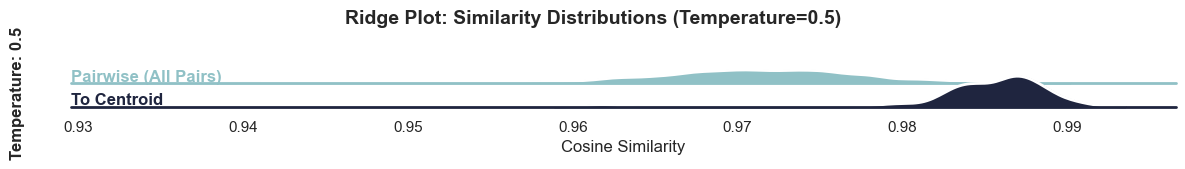

In [18]:
# Prepare data for ridge plot
# Create a DataFrame with both similarity distributions
ridge_data = pd.DataFrame({
    'Similarity': np.concatenate([sims_to_ref, sims_to_centroid]),
    'Type': ['Pairwise (All Pairs)'] * len(sims_to_ref) + ['To Centroid'] * len(sims_to_centroid)
})

# Set up the seaborn theme
sns.set_theme(style='white', rc={'axes.facecolor': (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(2, rot=-.25, light=.7)
g = sns.FacetGrid(ridge_data, row='Type', hue='Type', aspect=15, height=.8, palette=pal)

# Draw the densities
g.map(sns.kdeplot, 'Similarity',
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'Similarity', clip_on=False, color='w', lw=2, bw_adjust=.5)

# Add horizontal reference lines
g.refline(y=0, linewidth=2, linestyle='-', color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight='bold', color=color,
            ha='left', va='center', transform=ax.transAxes)

g.map(label, 'Similarity')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details
g.set_titles('')
g.set(yticks=[], ylabel='')
g.despine(bottom=True, left=True)

# Add title
g.figure.suptitle(f'Ridge Plot: Similarity Distributions (Temperature={SELECTED_TEMPERATURE})', 
                   fontsize=14, fontweight='bold', y=1.02)

plt.xlabel('Cosine Similarity', fontsize=12)
g.figure.text(0.02, 0.5, f'Temperature: {SELECTED_TEMPERATURE}', 
              va='center', ha='center', rotation='vertical', fontsize=12, fontweight='bold')
plt.show()

# Reset seaborn defaults
sns.reset_defaults()

### Temperature Comparison Analysis

Compare similarity distributions across different temperature levels to understand the impact of temperature on output consistency.

**Note:** This section only runs if data was loaded in multi-temperature mode.

In [ ]:
# =============================================================================
# TEMPERATURE COMPARISON ANALYSIS
# =============================================================================

if MULTI_TEMP_MODE:
    print("Computing similarity statistics across all temperatures...")
    
    temp_stats = []
    temp_similarities = {}
    
    for temp, temp_outputs in sorted(outputs_by_temp.items()):
        # Embed outputs for this temperature
        temp_embeddings = embed_texts(temp_outputs)
        
        # Compute pairwise similarities
        temp_pairwise = cosine_similarity(temp_embeddings)
        n = len(temp_embeddings)
        mask = ~np.eye(n, dtype=bool)
        temp_sims = temp_pairwise[mask]
        
        temp_similarities[temp] = temp_sims
        
        temp_stats.append({
            'temperature': temp,
            'n_outputs': len(temp_outputs),
            'mean_similarity': np.mean(temp_sims),
            'std_similarity': np.std(temp_sims),
            'min_similarity': np.min(temp_sims),
            'max_similarity': np.max(temp_sims)
        })
    
    # Create summary DataFrame
    temp_df = pd.DataFrame(temp_stats)
    
    print("\nSimilarity Statistics by Temperature:")
    print("=" * 80)
    print(temp_df.to_string(index=False))
    print("=" * 80)
    
    # Visualization: Mean similarity vs Temperature
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Mean similarity with error bars
    ax1 = axes[0]
    ax1.errorbar(temp_df['temperature'], temp_df['mean_similarity'], 
                 yerr=temp_df['std_similarity'], marker='o', capsize=5,
                 color='#3498db', linewidth=2, markersize=8)
    ax1.set_xlabel('Temperature', fontsize=12)
    ax1.set_ylabel('Mean Pairwise Similarity', fontsize=12)
    ax1.set_title('Output Consistency vs Temperature', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(temp_df['temperature'])
    
    # Plot 2: Box plot of similarities by temperature
    ax2 = axes[1]
    box_data = [temp_similarities[t] for t in sorted(temp_similarities.keys())]
    bp = ax2.boxplot(box_data, labels=[f'{t:.1f}' for t in sorted(temp_similarities.keys())],
                     patch_artist=True)
    
    # Color boxes by temperature (blue=cold, red=hot)
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(box_data)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_xlabel('Temperature', fontsize=12)
    ax2.set_ylabel('Pairwise Similarity', fontsize=12)
    ax2.set_title('Similarity Distribution by Temperature', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Ridge plot for temperature comparison
    print("\nGenerating ridge plot for temperature comparison...")
    
    # Prepare data for ridge plot
    ridge_temp_data = []
    for temp, sims in sorted(temp_similarities.items()):
        for sim in sims:
            ridge_temp_data.append({'Similarity': sim, 'Temperature': f'T={temp:.1f}'})
    
    ridge_temp_df = pd.DataFrame(ridge_temp_data)
    
    # Set up the seaborn theme
    sns.set_theme(style='white', rc={'axes.facecolor': (0, 0, 0, 0)})
    
    # Initialize the FacetGrid
    n_temps = len(temp_similarities)
    pal = sns.color_palette("coolwarm", n_temps)
    g = sns.FacetGrid(ridge_temp_df, row='Temperature', hue='Temperature', 
                      aspect=15, height=0.5, palette=pal)
    
    # Draw densities
    g.map(sns.kdeplot, 'Similarity', bw_adjust=0.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, 'Similarity', clip_on=False, color='w', lw=2, bw_adjust=0.5)
    
    # Reference line
    g.refline(y=0, linewidth=2, linestyle='-', color=None, clip_on=False)
    
    # Labels
    def label_ridge(x, color, label):
        ax = plt.gca()
        ax.text(0, 0.2, label, fontweight='bold', color=color,
                ha='left', va='center', transform=ax.transAxes)
    
    g.map(label_ridge, 'Similarity')
    
    g.figure.subplots_adjust(hspace=-0.25)
    g.set_titles('')
    g.set(yticks=[], ylabel='')
    g.despine(bottom=True, left=True)
    g.figure.suptitle('Similarity Distributions Across Temperatures', 
                      fontsize=14, fontweight='bold', y=1.02)
    
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.show()
    
    sns.reset_defaults()
else:
    print("Single temperature mode - skipping temperature comparison.")
    print(f"Selected temperature: {SELECTED_TEMPERATURE}")

### Individual Ridge Plots per Temperature

Generate ridge plots for each temperature showing both pairwise and centroid similarities.

This provides a detailed view of similarity distributions at each temperature level.

In [ ]:
# =============================================================================
# INDIVIDUAL RIDGE PLOTS PER TEMPERATURE
# =============================================================================

if MULTI_TEMP_MODE:
    
    print("Generating individual ridge plots for each temperature...")
    print(f"Processing {len(outputs_by_temp)} temperatures\n")
    
    # Process each temperature with progress tracking
    for temp in tqdm(sorted(outputs_by_temp.keys()), desc="Temperature", unit="temp"):
        temp_outputs = outputs_by_temp[temp]
        
        # Embed outputs for this temperature
        temp_embeddings = embed_texts(temp_outputs)
        
        # Compute pairwise similarities
        temp_pairwise = cosine_similarity(temp_embeddings)
        n = len(temp_embeddings)
        mask = ~np.eye(n, dtype=bool)
        temp_sims_pairwise = temp_pairwise[mask]
        
        # Compute centroid and similarities to centroid
        temp_centroid = compute_centroid(temp_embeddings)
        temp_sims_centroid = cosine_similarity(temp_embeddings, temp_centroid.reshape(1, -1)).flatten()
        
        # Prepare data for ridge plot
        ridge_data = pd.DataFrame({
            'Similarity': np.concatenate([temp_sims_pairwise, temp_sims_centroid]),
            'Type': ['Pairwise (All Pairs)'] * len(temp_sims_pairwise) + ['To Centroid'] * len(temp_sims_centroid)
        })
        
        # Set up the seaborn theme
        sns.set_theme(style='white', rc={'axes.facecolor': (0, 0, 0, 0)})
        
        # Initialize the FacetGrid object
        pal = sns.cubehelix_palette(2, rot=-.25, light=.7)
        g = sns.FacetGrid(ridge_data, row='Type', hue='Type', aspect=15, height=.8, palette=pal)
        
        # Draw the densities
        g.map(sns.kdeplot, 'Similarity',
              bw_adjust=.5, clip_on=False,
              fill=True, alpha=1, linewidth=1.5)
        g.map(sns.kdeplot, 'Similarity', clip_on=False, color='w', lw=2, bw_adjust=.5)
        
        # Add horizontal reference lines
        g.refline(y=0, linewidth=2, linestyle='-', color=None, clip_on=False)
        
        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight='bold', color=color,
                    ha='left', va='center', transform=ax.transAxes)
        
        g.map(label, 'Similarity')
        
        # Set the subplots to overlap
        g.figure.subplots_adjust(hspace=-.25)
        
        # Remove axes details
        g.set_titles('')
        g.set(yticks=[], ylabel='')
        g.despine(bottom=True, left=True)
        
        # Add title
        g.figure.suptitle(f'Ridge Plot: Similarity Distributions (Temperature={temp})', 
                           fontsize=14, fontweight='bold', y=1.02)
        
        plt.xlabel('Cosine Similarity', fontsize=12)
        g.figure.text(0.02, 0.5, f'Temperature: {temp}', 
                      va='center', ha='center', rotation='vertical', fontsize=12, fontweight='bold')
        plt.show()
        
        # Reset seaborn defaults
        sns.reset_defaults()
    
    print(f"\nCompleted ridge plots for all {len(outputs_by_temp)} temperatures.")
else:
    print("Single temperature mode - use the ridge plot in the previous cell.")

## Step 5: KDE Modeling

Fit a Kernel Density Estimate to model the smooth distribution of similarity scores.

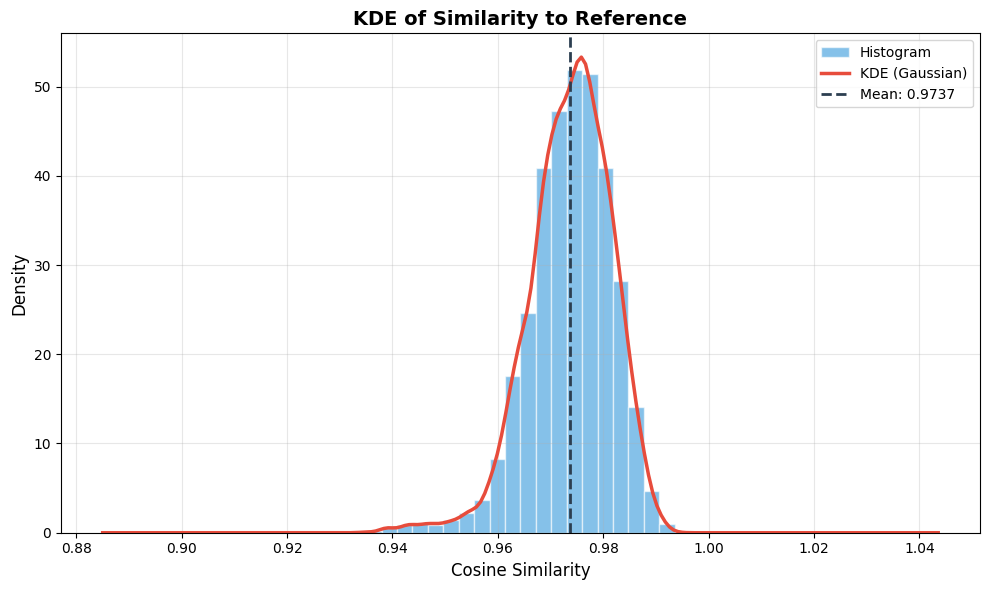

KDE fitted successfully


In [27]:
# Fit KDE to similarity-to-reference distribution
kde = gaussian_kde(sims_to_ref)

# Create smooth x-axis for plotting
x_range = np.linspace(min(sims_to_ref) - 0.05, max(sims_to_ref) + 0.05, 200)
kde_values = kde(x_range)

# Plot KDE
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram with density
ax.hist(sims_to_ref, bins=20, density=True, color='#3498db', edgecolor='white', alpha=0.6, label='Histogram')

# KDE curve
ax.plot(x_range, kde_values, color='#e74c3c', linewidth=2.5, label='KDE (Gaussian)')

# Mark mean
ax.axvline(np.mean(sims_to_ref), color='#2c3e50', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sims_to_ref):.4f}')

ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('KDE of Similarity to Reference', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"KDE fitted successfully")

## Step 6: Threshold Calibration

Calculate the threshold at the configured percentile (default: 5th percentile).

This means 95% of acceptable outputs will be **above** this threshold.

In [14]:
# Calculate threshold at different percentiles for comparison
percentiles_to_show = [1, 2, 3, 5, 10, 15, 20, 25, 50]
thresholds_by_pct = {p: np.percentile(sims_to_ref, p) for p in percentiles_to_show}

# Use configured percentile as our main threshold
threshold = np.percentile(sims_to_ref, THRESHOLD_PERCENTILE)

print("Threshold Calibration Results:")
print("=" * 60)
print(f"  {'Percentile':<15} {'Threshold':<15} {'Selected'}")
print("-" * 60)
for pct, thresh in thresholds_by_pct.items():
    selected = '<-- SELECTED' if THRESHOLD_PERCENTILE == pct else ''
    print(f"  {pct}th percentile:  {thresh:.4f}          {selected}")
print("=" * 60)
print(f"\nConfigured THRESHOLD_PERCENTILE: {THRESHOLD_PERCENTILE}")
print(f"Calibrated Threshold: {threshold:.4f}")
print(f"Interpretation: {100 - THRESHOLD_PERCENTILE}% of pairwise similarities are above this threshold")

Threshold Calibration Results:
  Percentile      Threshold       Selected
------------------------------------------------------------
  1th percentile:  0.9495          
  2th percentile:  0.9553          
  3th percentile:  0.9583          
  5th percentile:  0.9608          <-- SELECTED
  10th percentile:  0.9639          
  15th percentile:  0.9661          
  20th percentile:  0.9677          
  25th percentile:  0.9690          
  50th percentile:  0.9744          

Configured THRESHOLD_PERCENTILE: 5
Calibrated Threshold: 0.9608
Interpretation: 95% of pairwise similarities are above this threshold


## Step 7: Bootstrap Confidence Interval

Compute a confidence interval for our threshold using bootstrap resampling.

This gives us statistical rigor and uncertainty bounds.

In [15]:
# Bootstrap resampling for confidence interval
np.random.seed(42)  # For reproducibility

bootstrap_thresholds = []

print(f"Running {BOOTSTRAP_ITERATIONS} bootstrap iterations...")
for _ in tqdm(range(BOOTSTRAP_ITERATIONS)):
    # Resample with replacement
    sample = np.random.choice(sims_to_ref, size=len(sims_to_ref), replace=True)
    # Calculate threshold for this sample
    sample_threshold = np.percentile(sample, THRESHOLD_PERCENTILE)
    bootstrap_thresholds.append(sample_threshold)

bootstrap_thresholds = np.array(bootstrap_thresholds)

# Calculate confidence interval
alpha = 1 - CONFIDENCE_LEVEL
ci_low = np.percentile(bootstrap_thresholds, (alpha / 2) * 100)
ci_high = np.percentile(bootstrap_thresholds, (1 - alpha / 2) * 100)

print(f"\nBootstrap Results:")
print("=" * 50)
print(f"  Point Estimate (Threshold): {threshold:.4f}")
print(f"  {CONFIDENCE_LEVEL * 100:.0f}% Confidence Interval: [{ci_low:.4f}, {ci_high:.4f}]")
print(f"  CI Width: {ci_high - ci_low:.4f}")
print("=" * 50)

Running 100000 bootstrap iterations...


100%|██████████| 100000/100000 [00:27<00:00, 3676.60it/s]


Bootstrap Results:
  Point Estimate (Threshold): 0.9608
  95% Confidence Interval: [0.9605, 0.9612]
  CI Width: 0.0007


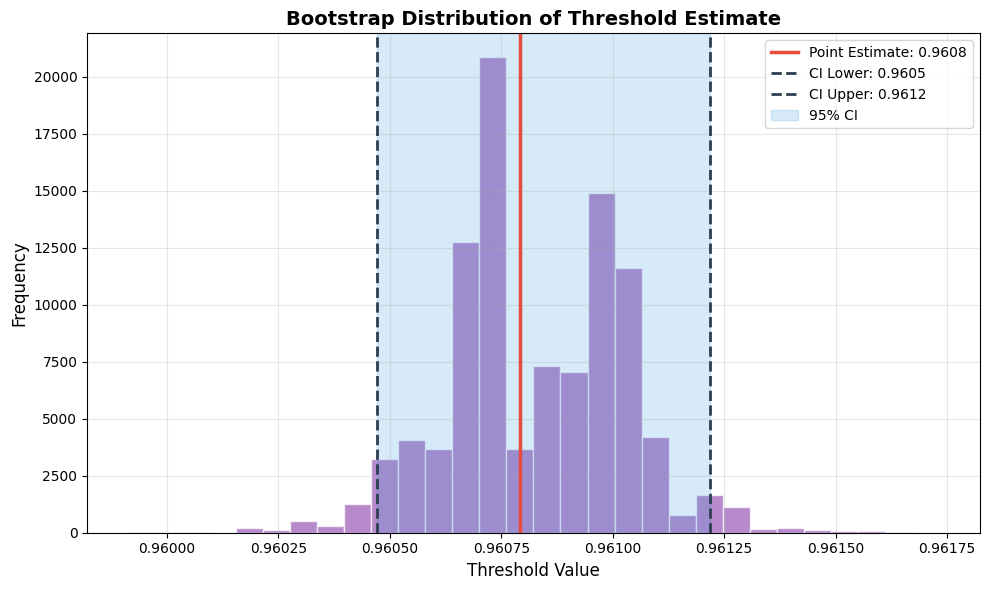

In [16]:
# Visualize bootstrap distribution
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(bootstrap_thresholds, bins=30, color='#9b59b6', edgecolor='white', alpha=0.7)
ax.axvline(threshold, color='#e74c3c', linestyle='-', linewidth=2.5, label=f'Point Estimate: {threshold:.4f}')
ax.axvline(ci_low, color='#2c3e50', linestyle='--', linewidth=2, label=f'CI Lower: {ci_low:.4f}')
ax.axvline(ci_high, color='#2c3e50', linestyle='--', linewidth=2, label=f'CI Upper: {ci_high:.4f}')

# Shade CI region
ax.axvspan(ci_low, ci_high, alpha=0.2, color='#3498db', label=f'{CONFIDENCE_LEVEL * 100:.0f}% CI')

ax.set_xlabel('Threshold Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Bootstrap Distribution of Threshold Estimate', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 8: Runtime Evaluation Functions

Create functions to evaluate new outputs against the calibrated threshold.

In [21]:
def evaluate_output_score(text: str, calibration_embs: np.ndarray) -> float:
    """
    Compute similarity score for a single output against all calibration embeddings.
    
    Args:
        text: The output text to evaluate
        calibration_embs: All calibration embeddings (shape: N x embedding_dim)
    
    Returns:
        Mean cosine similarity to all calibration outputs
    """
    emb = embed_texts([text])[0]
    # Compare to ALL calibration embeddings
    similarities = cosine_similarity(emb.reshape(1, -1), calibration_embs)[0]
    # Return mean similarity (consistent with pairwise calibration)
    score = np.mean(similarities)
    return score


def evaluate_output(text: str, calibration_embs: np.ndarray, threshold: float) -> tuple[bool, float]:
    """
    Evaluate if an output passes the threshold.
    
    Args:
        text: The output text to evaluate
        calibration_embs: All calibration embeddings (shape: N x embedding_dim)
        threshold: Minimum similarity threshold
    
    Returns:
        Tuple of (passed: bool, score: float)
    """
    score = evaluate_output_score(text, calibration_embs)
    passed = score >= threshold
    return passed, score


def evaluate_with_retry(
    system_prompt: str,
    user_prompt: str,
    calibration_embs: np.ndarray,
    threshold: float,
    max_retries: int = 3,
    temp: float = TEMPERATURE
) -> tuple[str, float, str, int]:
    """
    Generate output with retry logic if below threshold.
    
    Args:
        system_prompt: System prompt for generation
        user_prompt: User prompt for generation
        calibration_embs: All calibration embeddings (shape: N x embedding_dim)
        threshold: Minimum similarity threshold
        max_retries: Maximum number of attempts
        temp: Temperature for generation
    
    Returns:
        Tuple of (output, score, decision, attempts)
        Decision is one of: "ACCEPT", "ESCALATE"
    """
    for attempt in range(max_retries):
        output = generate_output(system_prompt, user_prompt, temp)
        passed, score = evaluate_output(output, calibration_embs, threshold)
        
        if passed:
            return output, score, "ACCEPT", attempt + 1
    
    # All retries exhausted
    return output, score, "ESCALATE", max_retries


print("Runtime evaluation functions defined:")

Runtime evaluation functions defined:


## Step 9: Test Runtime Evaluation

Test the evaluation function with a new generated output.

In [22]:
# Generate a new test output
print("Generating new test output...")
new_output = generate_output(SYSTEM_PROMPT, USER_PROMPT, TEMPERATURE)

# Evaluate against threshold
passed, score = evaluate_output(new_output, calibration_embeddings, threshold)

print("\n" + "=" * 60)
print("RUNTIME EVALUATION RESULT")
print("=" * 60)
print(f"Score:     {score:.4f}")
print(f"Threshold: {threshold:.4f}")
print(f"CI:        [{ci_low:.4f}, {ci_high:.4f}]")
print("-" * 60)

if passed:
    print(f"Decision:  ACCEPT")
else:
    print(f"Decision:  RETRY (score below threshold)")
    
print("=" * 60)

Generating new test output...

RUNTIME EVALUATION RESULT
Score:     0.9736
Threshold: 0.9608
CI:        [0.9605, 0.9612]
------------------------------------------------------------
Decision:  ACCEPT


In [23]:
# Test the retry logic (with higher threshold to force retries)
print("Testing accept/retry/escalate logic...")
print("(Using slightly higher threshold to demonstrate retry behavior)")

# Use a threshold that will likely trigger at least one retry
test_threshold = np.percentile(sims_to_ref, 50)  # 50th percentile = median

output, score, decision, attempts = evaluate_with_retry(
    SYSTEM_PROMPT, USER_PROMPT, calibration_embeddings, 
    test_threshold, max_retries=3
)

print(f"\nResult:")
print(f"  Decision: {decision}")
print(f"  Attempts: {attempts}")
print(f"  Final Score: {score:.4f}")
print(f"  Test Threshold: {test_threshold:.4f}")

Testing accept/retry/escalate logic...
(Using slightly higher threshold to demonstrate retry behavior)

Result:
  Decision: ACCEPT
  Attempts: 1
  Final Score: 0.9760
  Test Threshold: 0.9744


## Step 9b: Hypothesis Testing for Output Evaluation

Add formal statistical hypothesis testing to make accept/reject decisions more rigorous.

### Hypothesis Framework

```
H0 (Null Hypothesis):     The output similarity score is at or below the threshold (score ≤ T)
H1 (Alternative):         The output similarity score is above the threshold (score > T)

Decision Rule:
- p-value < α  →  Reject H0  →  ACCEPT output (statistically confident it exceeds threshold)
- p-value ≥ α  →  Fail to reject H0  →  RETRY/ESCALATE (insufficient evidence)
```

### Why This Approach?

- **Conservative by default**: Assumes output is NOT acceptable until proven otherwise
- **Controls false acceptance rate**: Setting α=0.05 means at most 5% chance of accepting bad output
- **Two evaluation modes**:
  - **Single output**: Z-test using calibration distribution parameters
  - **Batch output**: T-test for multiple outputs (more robust for small samples)

In [24]:
def evaluate_output_hypothesis(
    text: str, 
    calibration_embs: np.ndarray, 
    threshold: float,
    baseline_mean: float,
    baseline_std: float,
    alpha: float = 0.05
) -> dict:
    """
    Evaluate a single output using hypothesis testing.
    
    Hypothesis:
        H0: score <= threshold (output is NOT acceptable)
        H1: score > threshold (output IS acceptable)
    
    Uses z-test with calibration distribution parameters.
    
    Args:
        text: Output text to evaluate
        calibration_embs: All calibration embeddings (shape: N x embedding_dim)
        threshold: Calibrated threshold value
        baseline_mean: Mean from calibration distribution
        baseline_std: Std from calibration distribution
        alpha: Significance level (default 0.05)
    
    Returns:
        Dictionary with score, z_score, p_value, and decision
    """
    # Compute similarity score
    score = evaluate_output_score(text, calibration_embs)
    
    # Z-score: how many standard deviations above the threshold
    z_score = (score - threshold) / baseline_std
    
    # One-tailed p-value (upper tail)
    # P(Z > z_score) under H0
    p_value = 1 - norm.cdf(z_score)
    
    # Decision based on significance level
    reject_h0 = p_value < alpha
    decision = "ACCEPT" if reject_h0 else "RETRY"
    
    return {
        "score": float(score),
        "threshold": float(threshold),
        "z_score": float(z_score),
        "p_value": float(p_value),
        "alpha": alpha,
        "reject_h0": reject_h0,
        "decision": decision,
        "interpretation": f"{'Reject' if reject_h0 else 'Fail to reject'} H0 at α={alpha}"
    }


print("Single output hypothesis test function defined")

Single output hypothesis test function defined


In [25]:
def evaluate_batch_hypothesis(
    scores: np.ndarray,
    threshold: float,
    alpha: float = 0.05
) -> dict:
    """
    Evaluate a batch of outputs using one-sample t-test.
    
    Hypothesis:
        H0: mean(scores) <= threshold (batch is NOT acceptable on average)
        H1: mean(scores) > threshold (batch IS acceptable on average)
    
    Uses t-test which is more robust for small samples.
    
    Args:
        scores: Array of similarity scores
        threshold: Calibrated threshold value
        alpha: Significance level (default 0.05)
    
    Returns:
        Dictionary with statistics, p_value, and decision
    """
    # One-sample t-test
    t_stat, p_value_two_tailed = ttest_1samp(scores, threshold)
    
    # Convert to one-tailed (we only care if mean > threshold)
    # If t_stat > 0, mean is above threshold, use half the two-tailed p-value
    # If t_stat < 0, mean is below threshold, p-value for upper tail is 1 - half
    if t_stat > 0:
        p_value = p_value_two_tailed / 2
    else:
        p_value = 1 - p_value_two_tailed / 2
    
    # Decision
    reject_h0 = p_value < alpha
    decision = "ACCEPT" if reject_h0 else "ESCALATE"
    
    return {
        "n_samples": len(scores),
        "mean_score": float(np.mean(scores)),
        "std_score": float(np.std(scores, ddof=1)),  # Sample std
        "threshold": float(threshold),
        "t_statistic": float(t_stat),
        "p_value": float(p_value),
        "alpha": alpha,
        "reject_h0": reject_h0,
        "decision": decision,
        "interpretation": f"{'Reject' if reject_h0 else 'Fail to reject'} H0 at α={alpha}"
    }


def generate_and_test_batch(
    system_prompt: str,
    user_prompt: str,
    calibration_embs: np.ndarray,
    threshold: float,
    n_samples: int = 10,
    temp: float = 0.9,
    alpha: float = 0.05
) -> dict:
    """
    Generate a batch of outputs and run hypothesis test.
    
    Args:
        system_prompt: System prompt for generation
        user_prompt: User prompt for generation
        calibration_embs: All calibration embeddings (shape: N x embedding_dim)
        threshold: Calibrated threshold
        n_samples: Number of outputs to generate
        temp: Temperature for generation
        alpha: Significance level
    
    Returns:
        Dictionary with outputs, scores, and hypothesis test results
    """
    # Generate outputs
    outputs = generate_batch_outputs(system_prompt, user_prompt, n_samples, temp)
    
    # Embed and compute scores (mean similarity to all calibration embeddings)
    embeddings = embed_texts(outputs)
    # Compute similarity of each output to all calibration embeddings, then take mean
    all_sims = cosine_similarity(embeddings, calibration_embs)
    scores = np.mean(all_sims, axis=1)  # Mean similarity for each output
    
    # Run hypothesis test
    test_result = evaluate_batch_hypothesis(scores, threshold, alpha)
    
    return {
        "outputs": outputs,
        "scores": scores,
        "test_result": test_result
    }


print("Batch hypothesis test functions defined")

Batch hypothesis test functions defined


In [28]:
# Store baseline statistics for hypothesis testing
# (These are also used later for drift detection)
baseline_stats = {
    "scores": sims_to_ref.copy(),
    "mean": np.mean(sims_to_ref),
    "std": np.std(sims_to_ref),
    "kde": kde,
    "threshold": threshold,
    "ci_low": ci_low,
    "ci_high": ci_high
}

print("Baseline Statistics for Hypothesis Testing (Pairwise):")
print(f"  Mean: {baseline_stats['mean']:.4f}")
print(f"  Std:  {baseline_stats['std']:.4f}")
print(f"  N samples: {len(baseline_stats['scores'])}")

# Compute EMPIRICAL baseline stats for mean scores (Option 3)
# For each output, compute mean similarity to all OTHER outputs
mean_scores_per_output = []
for i in range(n_outputs):
    other_sims = pairwise_sims[i, mask[i]]  # Similarities to all other outputs (99 values)
    mean_scores_per_output.append(np.mean(other_sims))

mean_scores_per_output = np.array(mean_scores_per_output)

# Store empirical baseline stats (based on mean scores, not individual pairwise)
baseline_stats_empirical = {
    "scores": mean_scores_per_output,
    "mean": np.mean(mean_scores_per_output),
    "std": np.std(mean_scores_per_output),
}

print("\nBaseline Statistics for Hypothesis Testing (Empirical Mean Scores):")
print(f"  Mean: {baseline_stats_empirical['mean']:.4f}")
print(f"  Std:  {baseline_stats_empirical['std']:.4f}")
print(f"  N samples: {len(baseline_stats_empirical['scores'])}")

# Compute CLT-adjusted std (Option 1)
clt_adjusted_std = baseline_stats['std'] / np.sqrt(n_outputs)
print(f"\nCLT-Adjusted Std (Option 1): {clt_adjusted_std:.6f}")
print(f"Empirical Std (Option 3):    {baseline_stats_empirical['std']:.6f}")

Baseline Statistics for Hypothesis Testing (Pairwise):
  Mean: 0.9737
  Std:  0.0078
  N samples: 9900

Baseline Statistics for Hypothesis Testing (Empirical Mean Scores):
  Mean: 0.9737
  Std:  0.0037
  N samples: 100

CLT-Adjusted Std (Option 1): 0.000780
Empirical Std (Option 3):    0.003689


### Test: Single Output Hypothesis Evaluation (Option 1 - CLT Adjustment)

In [29]:
# OPTION 1: CLT-Adjusted Hypothesis Test
# Uses baseline_std / sqrt(n) to account for the fact that runtime score is a mean

print("Generating new output for hypothesis test...")
test_output_hyp = generate_output(SYSTEM_PROMPT, USER_PROMPT, TEMPERATURE)

# Run hypothesis test with CLT-adjusted std
hyp_result_opt1 = evaluate_output_hypothesis(
    text=test_output_hyp,
    calibration_embs=calibration_embeddings,
    threshold=threshold,
    baseline_mean=baseline_stats["mean"],
    baseline_std=clt_adjusted_std,  # CLT adjustment: std / sqrt(n)
    alpha=0.05
)

print("\n" + "=" * 70)
print("OPTION 1: CLT-ADJUSTED HYPOTHESIS TEST")
print("=" * 70)
print(f"Method: baseline_std / sqrt(n) = {baseline_stats['std']:.4f} / sqrt({n_outputs}) = {clt_adjusted_std:.6f}")
print("-" * 70)
print(f"H0: Score ≤ {hyp_result_opt1['threshold']:.4f} (output not acceptable)")
print(f"H1: Score > {hyp_result_opt1['threshold']:.4f} (output acceptable)")
print("-" * 70)
print(f"Observed Score:  {hyp_result_opt1['score']:.4f}")
print(f"Threshold:       {hyp_result_opt1['threshold']:.4f}")
print(f"Z-Score:         {hyp_result_opt1['z_score']:.4f}")
print(f"P-Value:         {hyp_result_opt1['p_value']:.6f}")
print(f"Alpha (α):       {hyp_result_opt1['alpha']}")
print("-" * 70)
print(f"Decision:        {hyp_result_opt1['interpretation']}")
print(f"Action:          {hyp_result_opt1['decision']}")
print("=" * 70)

Generating new output for hypothesis test...

OPTION 1: CLT-ADJUSTED HYPOTHESIS TEST
Method: baseline_std / sqrt(n) = 0.0078 / sqrt(100) = 0.000780
----------------------------------------------------------------------
H0: Score ≤ 0.9608 (output not acceptable)
H1: Score > 0.9608 (output acceptable)
----------------------------------------------------------------------
Observed Score:  0.9760
Threshold:       0.9608
Z-Score:         19.4635
P-Value:         0.000000
Alpha (α):       0.05
----------------------------------------------------------------------
Decision:        Reject H0 at α=0.05
Action:          ACCEPT


### Test: Single Output Hypothesis Evaluation (Option 3 - Empirical Std)

In [30]:
# OPTION 3: Empirical Hypothesis Test
# Uses std computed from actual mean scores per output (more accurate)

# Run hypothesis test with empirically computed std
# (reuse the same test output from Option 1 for fair comparison)
hyp_result_opt3 = evaluate_output_hypothesis(
    text=test_output_hyp,
    calibration_embs=calibration_embeddings,
    threshold=threshold,
    baseline_mean=baseline_stats_empirical["mean"],
    baseline_std=baseline_stats_empirical["std"],  # Empirically measured std
    alpha=0.05
)

print("=" * 70)
print("OPTION 3: EMPIRICAL HYPOTHESIS TEST")
print("=" * 70)
print(f"Method: Empirically computed std from {n_outputs} mean scores = {baseline_stats_empirical['std']:.6f}")
print("-" * 70)
print(f"H0: Score ≤ {hyp_result_opt3['threshold']:.4f} (output not acceptable)")
print(f"H1: Score > {hyp_result_opt3['threshold']:.4f} (output acceptable)")
print("-" * 70)
print(f"Observed Score:  {hyp_result_opt3['score']:.4f}")
print(f"Threshold:       {hyp_result_opt3['threshold']:.4f}")
print(f"Z-Score:         {hyp_result_opt3['z_score']:.4f}")
print(f"P-Value:         {hyp_result_opt3['p_value']:.6f}")
print(f"Alpha (α):       {hyp_result_opt3['alpha']}")
print("-" * 70)
print(f"Decision:        {hyp_result_opt3['interpretation']}")
print(f"Action:          {hyp_result_opt3['decision']}")
print("=" * 70)

# Comparison summary
print("\n" + "=" * 70)
print("COMPARISON: Option 1 vs Option 3")
print("=" * 70)
print(f"Same test output score: {hyp_result_opt1['score']:.4f}")
print(f"")
print(f"Option 1 (CLT):      Std={clt_adjusted_std:.6f}, Z={hyp_result_opt1['z_score']:.2f}, P={hyp_result_opt1['p_value']:.6f}, Decision={hyp_result_opt1['decision']}")
print(f"Option 3 (Empirical): Std={baseline_stats_empirical['std']:.6f}, Z={hyp_result_opt3['z_score']:.2f}, P={hyp_result_opt3['p_value']:.6f}, Decision={hyp_result_opt3['decision']}")

OPTION 3: EMPIRICAL HYPOTHESIS TEST
Method: Empirically computed std from 100 mean scores = 0.003689
----------------------------------------------------------------------
H0: Score ≤ 0.9608 (output not acceptable)
H1: Score > 0.9608 (output acceptable)
----------------------------------------------------------------------
Observed Score:  0.9760
Threshold:       0.9608
Z-Score:         4.1186
P-Value:         0.000019
Alpha (α):       0.05
----------------------------------------------------------------------
Decision:        Reject H0 at α=0.05
Action:          ACCEPT

COMPARISON: Option 1 vs Option 3
Same test output score: 0.9760

Option 1 (CLT):      Std=0.000780, Z=19.46, P=0.000000, Decision=ACCEPT
Option 3 (Empirical): Std=0.003689, Z=4.12, P=0.000019, Decision=ACCEPT


### Test: Batch Output Hypothesis Evaluation

Generate multiple outputs and use t-test for more robust statistical inference.

In [96]:
# Test batch hypothesis evaluation
N_BATCH_SAMPLES = 15  # Generate 15 outputs for the test

print(f"Generating {N_BATCH_SAMPLES} outputs for batch hypothesis test...")
batch_result = generate_and_test_batch(
    system_prompt=SYSTEM_PROMPT,
    user_prompt=USER_PROMPT,
    calibration_embs=calibration_embeddings,
    threshold=threshold,
    n_samples=N_BATCH_SAMPLES,
    temp=TEMPERATURE,
    alpha=0.05
)

test_result = batch_result["test_result"]
batch_scores = batch_result["scores"]

print("\n" + "=" * 70)
print("BATCH OUTPUT HYPOTHESIS TEST RESULT (T-Test)")
print("=" * 70)
print(f"H0: Mean(scores) ≤ {test_result['threshold']:.4f} (batch not acceptable on average)")
print(f"H1: Mean(scores) > {test_result['threshold']:.4f} (batch acceptable on average)")
print("-" * 70)
print(f"Sample Size (n):    {test_result['n_samples']}")
print(f"Mean Score:         {test_result['mean_score']:.4f}")
print(f"Std Score:          {test_result['std_score']:.4f}")
print(f"Threshold:          {test_result['threshold']:.4f}")
print(f"T-Statistic:        {test_result['t_statistic']:.4f}")
print(f"P-Value:            {test_result['p_value']:.6f}")
print(f"Alpha (α):          {test_result['alpha']}")
print("-" * 70)
print(f"Decision:           {test_result['interpretation']}")
print(f"Action:             {test_result['decision']}")
print("=" * 70)

# Show individual scores
print(f"\nIndividual Scores (sorted):")
for i, score in enumerate(sorted(batch_scores, reverse=True)):
    status = "above" if score >= threshold else "BELOW"
    print(f"  {i+1:2}. {score:.4f} ({status} threshold)")

Generating 15 outputs for batch hypothesis test...


Generating outputs: 100%|██████████| 15/15 [03:27<00:00, 13.81s/it]



BATCH OUTPUT HYPOTHESIS TEST RESULT (T-Test)
H0: Mean(scores) ≤ 0.9608 (batch not acceptable on average)
H1: Mean(scores) > 0.9608 (batch acceptable on average)
----------------------------------------------------------------------
Sample Size (n):    15
Mean Score:         0.9732
Std Score:          0.0041
Threshold:          0.9608
T-Statistic:        11.7275
P-Value:            0.000000
Alpha (α):          0.05
----------------------------------------------------------------------
Decision:           Reject H0 at α=0.05
Action:             ACCEPT

Individual Scores (sorted):
   1. 0.9768 (above threshold)
   2. 0.9767 (above threshold)
   3. 0.9763 (above threshold)
   4. 0.9755 (above threshold)
   5. 0.9752 (above threshold)
   6. 0.9752 (above threshold)
   7. 0.9748 (above threshold)
   8. 0.9747 (above threshold)
   9. 0.9739 (above threshold)
  10. 0.9735 (above threshold)
  11. 0.9725 (above threshold)
  12. 0.9714 (above threshold)
  13. 0.9705 (above threshold)
  14. 0.970

### Visualization: Option 1 (CLT-Adjusted) Z-Test

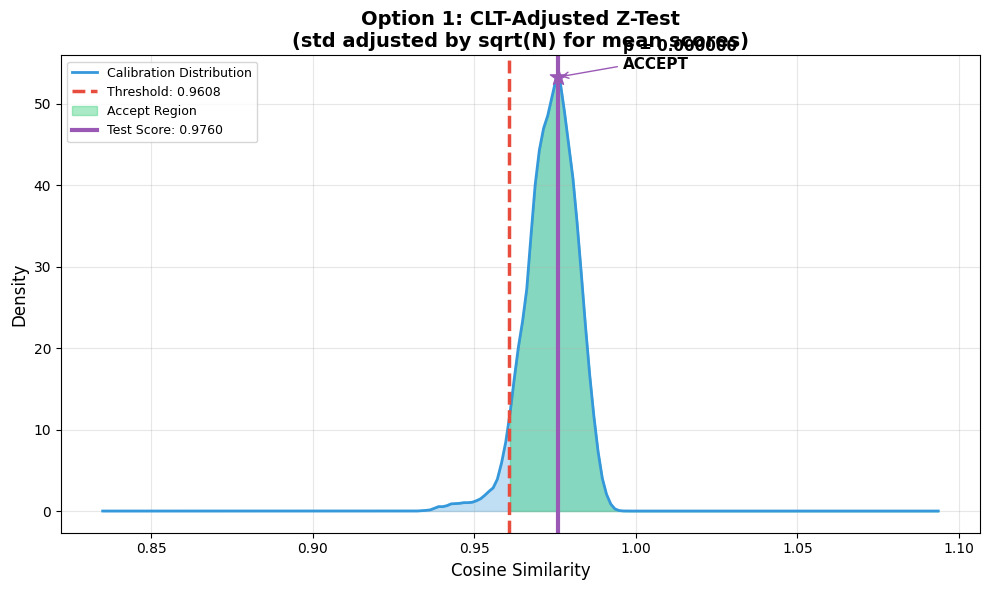


Option 1 Result: ACCEPT (p = 0.000000)
Z-Score: 19.4635


In [31]:
# Visualization for Option 1 (CLT-Adjusted)
fig, ax = plt.subplots(figsize=(10, 6))

# Common setup
x_range = np.linspace(
    min(baseline_stats["scores"]) - 0.1, 
    max(baseline_stats["scores"]) + 0.1, 
    200
)
kde_baseline = gaussian_kde(baseline_stats["scores"])

# Plot the calibration distribution
ax.plot(x_range, kde_baseline(x_range), color='#3498db', linewidth=2, label='Calibration Distribution')
ax.fill_between(x_range, kde_baseline(x_range), alpha=0.3, color='#3498db')

# Mark threshold
ax.axvline(threshold, color='#e74c3c', linestyle='--', linewidth=2.5, label=f'Threshold: {threshold:.4f}')

# Shade rejection region (above threshold = ACCEPT zone)
x_accept = x_range[x_range >= threshold]
ax.fill_between(x_accept, kde_baseline(x_accept), alpha=0.4, color='#2ecc71', label='Accept Region')

# Mark the test output score
ax.axvline(hyp_result_opt1['score'], color='#9b59b6', linestyle='-', linewidth=3, 
           label=f'Test Score: {hyp_result_opt1["score"]:.4f}')
ax.scatter([hyp_result_opt1['score']], [kde_baseline(hyp_result_opt1['score'])], 
           color='#9b59b6', s=150, zorder=5, marker='*')

# Add p-value annotation
ax.annotate(f'p = {hyp_result_opt1["p_value"]:.6f}\n{hyp_result_opt1["decision"]}', 
            xy=(hyp_result_opt1['score'], kde_baseline(hyp_result_opt1['score'])),
            xytext=(hyp_result_opt1['score'] + 0.02, kde_baseline(hyp_result_opt1['score']) + 1),
            fontsize=11, fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#9b59b6'))

ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Option 1: CLT-Adjusted Z-Test\n(std adjusted by sqrt(N) for mean scores)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print result summary
print(f"\nOption 1 Result: {hyp_result_opt1['decision']} (p = {hyp_result_opt1['p_value']:.6f})")
print(f"Z-Score: {hyp_result_opt1['z_score']:.4f}")

### Visualization: Option 3 (Empirical) Z-Test

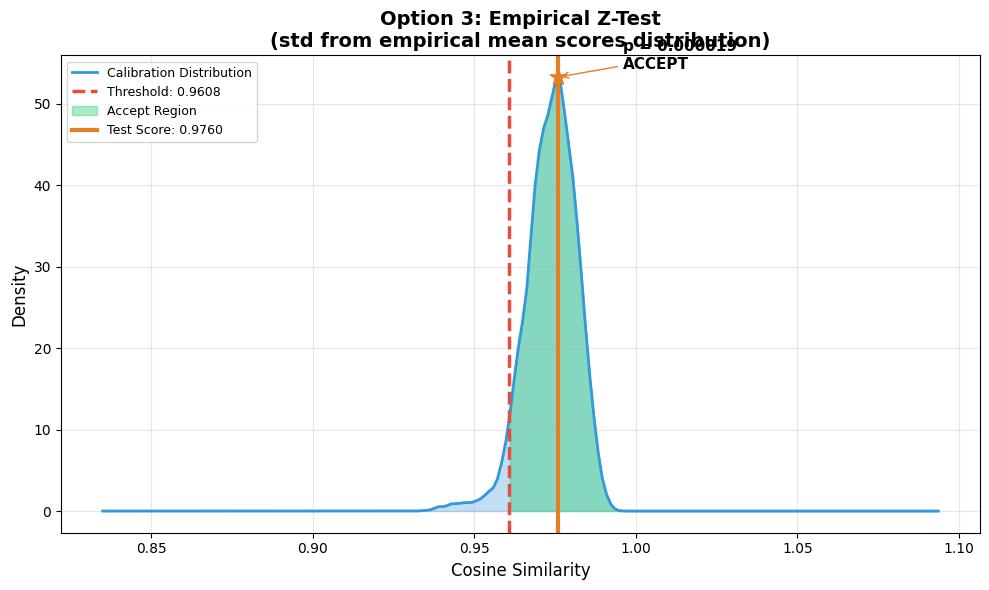


Option 3 Result: ACCEPT (p = 0.000019)
Z-Score: 4.1186


In [32]:
# Visualization for Option 3 (Empirical)
fig, ax = plt.subplots(figsize=(10, 6))

# Common setup
x_range = np.linspace(
    min(baseline_stats["scores"]) - 0.1, 
    max(baseline_stats["scores"]) + 0.1, 
    200
)
kde_baseline = gaussian_kde(baseline_stats["scores"])

# Plot the calibration distribution
ax.plot(x_range, kde_baseline(x_range), color='#3498db', linewidth=2, label='Calibration Distribution')
ax.fill_between(x_range, kde_baseline(x_range), alpha=0.3, color='#3498db')

# Mark threshold
ax.axvline(threshold, color='#e74c3c', linestyle='--', linewidth=2.5, label=f'Threshold: {threshold:.4f}')

# Shade rejection region (above threshold = ACCEPT zone)
x_accept = x_range[x_range >= threshold]
ax.fill_between(x_accept, kde_baseline(x_accept), alpha=0.4, color='#2ecc71', label='Accept Region')

# Mark the test output score
ax.axvline(hyp_result_opt3['score'], color='#e67e22', linestyle='-', linewidth=3, 
           label=f'Test Score: {hyp_result_opt3["score"]:.4f}')
ax.scatter([hyp_result_opt3['score']], [kde_baseline(hyp_result_opt3['score'])], 
           color='#e67e22', s=150, zorder=5, marker='*')

# Add p-value annotation
ax.annotate(f'p = {hyp_result_opt3["p_value"]:.6f}\n{hyp_result_opt3["decision"]}', 
            xy=(hyp_result_opt3['score'], kde_baseline(hyp_result_opt3['score'])),
            xytext=(hyp_result_opt3['score'] + 0.02, kde_baseline(hyp_result_opt3['score']) + 1),
            fontsize=11, fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#e67e22'))

ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Option 3: Empirical Z-Test\n(std from empirical mean scores distribution)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print result summary
print(f"\nOption 3 Result: {hyp_result_opt3['decision']} (p = {hyp_result_opt3['p_value']:.6f})")
print(f"Z-Score: {hyp_result_opt3['z_score']:.4f}")

### Visualization: Batch T-Test

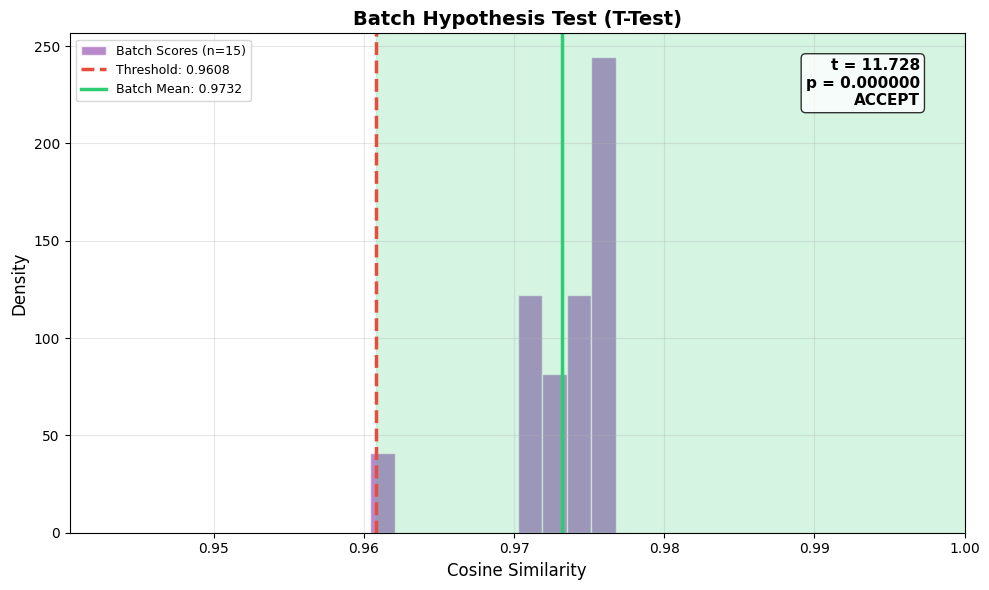


Batch Test Result: ACCEPT (p = 0.000000)
T-Statistic: 11.7275


In [101]:
# Visualization for Batch T-Test
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram of batch scores
ax.hist(batch_scores, bins=10, color='#9b59b6', edgecolor='white', alpha=0.7, 
        label=f'Batch Scores (n={len(batch_scores)})', density=True)

# Mark threshold
ax.axvline(threshold, color='#e74c3c', linestyle='--', linewidth=2.5, 
           label=f'Threshold: {threshold:.4f}')

# Mark batch mean
ax.axvline(test_result['mean_score'], color='#2ecc71', linestyle='-', linewidth=2.5, 
           label=f'Batch Mean: {test_result["mean_score"]:.4f}')

# Shade based on decision
if test_result['reject_h0']:
    ax.axvspan(threshold, max(batch_scores) + 0.05, alpha=0.2, color='#2ecc71')
else:
    ax.axvspan(min(batch_scores) - 0.05, threshold, alpha=0.2, color='#e74c3c')

# Add annotation
result_text = f't = {test_result["t_statistic"]:.3f}\np = {test_result["p_value"]:.6f}\n{test_result["decision"]}'
ax.annotate(result_text, xy=(0.95, 0.95), xycoords='axes fraction',
            fontsize=11, fontweight='bold', ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Batch Hypothesis Test (T-Test)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

# Set x-axis limits to valid cosine similarity range
ax.set_xlim(min(min(batch_scores), threshold) - 0.02, 1.0)

plt.tight_layout()
plt.show()

# Print result summary
print(f"\nBatch Test Result: {test_result['decision']} (p = {test_result['p_value']:.6f})")
print(f"T-Statistic: {test_result['t_statistic']:.4f}")

### Hypothesis Testing Summary

In [102]:
# Summary of all hypothesis tests
print("=" * 70)
print("HYPOTHESIS TESTING SUMMARY")
print("=" * 70)
print(f"\nSingle Output Test (same test output for both options):")
print(f"  Score: {hyp_result_opt1['score']:.4f}")
print(f"")
print(f"Option 1 (CLT-Adjusted):")
print(f"  - Uses baseline std / sqrt(N) = {clt_adjusted_std:.6f}")
print(f"  - Z-Score: {hyp_result_opt1['z_score']:.4f}")
print(f"  - P-Value: {hyp_result_opt1['p_value']:.6f}")
print(f"  - Decision: {hyp_result_opt1['decision']}")
print(f"")
print(f"Option 3 (Empirical):")
print(f"  - Uses empirical std of mean scores = {baseline_stats_empirical['std']:.6f}")
print(f"  - Z-Score: {hyp_result_opt3['z_score']:.4f}")
print(f"  - P-Value: {hyp_result_opt3['p_value']:.6f}")
print(f"  - Decision: {hyp_result_opt3['decision']}")
print(f"")
print(f"Batch Test (n={test_result['n_samples']}):")
print(f"  - Mean Score: {test_result['mean_score']:.4f}")
print(f"  - T-Statistic: {test_result['t_statistic']:.4f}")
print(f"  - P-Value: {test_result['p_value']:.6f}")
print(f"  - Decision: {test_result['decision']}")
print("=" * 70)

HYPOTHESIS TESTING SUMMARY

Single Output Test (same test output for both options):
  Score: 0.9709

Option 1 (CLT-Adjusted):
  - Uses baseline std / sqrt(N) = 0.000781
  - Z-Score: 12.8978
  - P-Value: 0.000000
  - Decision: ACCEPT

Option 3 (Empirical):
  - Uses empirical std of mean scores = 0.003691
  - Z-Score: 2.7286
  - P-Value: 0.003180
  - Decision: ACCEPT

Batch Test (n=15):
  - Mean Score: 0.9732
  - T-Statistic: 11.7275
  - P-Value: 0.000000
  - Decision: ACCEPT


## Step 10: Drift Detection

Implement drift detection to monitor when the model behavior changes and recalibration may be needed.

In [103]:
# baseline_stats was already computed in the hypothesis testing section
# Verify it's available for drift detection
print("Baseline Statistics (from earlier calibration):")
print(f"  Mean: {baseline_stats['mean']:.4f}")
print(f"  Std:  {baseline_stats['std']:.4f}")
print(f"  N samples: {len(baseline_stats['scores'])}")

Baseline Statistics (from earlier calibration):
  Mean: 0.9737
  Std:  0.0078
  N samples: 9900


In [104]:
def detect_drift_ks(baseline_scores: np.ndarray, new_scores: np.ndarray, alpha: float = 0.05) -> dict:
    """
    Detect drift using the Kolmogorov-Smirnov test.
    
    The KS test compares two distributions and detects if they're statistically different.
    
    Args:
        baseline_scores: Array of baseline similarity scores
        new_scores: Array of new similarity scores
        alpha: Significance level (default 0.05)
    
    Returns:
        Dictionary with drift_detected, ks_statistic, p_value
    """
    statistic, p_value = ks_2samp(baseline_scores, new_scores)
    drift_detected = p_value < alpha
    
    return {
        "drift_detected": drift_detected,
        "ks_statistic": statistic,
        "p_value": p_value,
        "alpha": alpha
    }


def detect_drift_mean(
    baseline_scores: np.ndarray, 
    new_scores: np.ndarray, 
    z_threshold: float = 2.0
) -> dict:
    """
    Detect drift by checking if the mean has shifted significantly.
    
    Args:
        baseline_scores: Array of baseline similarity scores
        new_scores: Array of new similarity scores
        z_threshold: Number of standard deviations for drift detection
    
    Returns:
        Dictionary with drift_detected, z_score, baseline_mean, new_mean
    """
    baseline_mean = np.mean(baseline_scores)
    baseline_std = np.std(baseline_scores)
    new_mean = np.mean(new_scores)
    
    # Calculate z-score of the difference
    z_score = abs(new_mean - baseline_mean) / (baseline_std / np.sqrt(len(new_scores)))
    drift_detected = z_score > z_threshold
    
    return {
        "drift_detected": drift_detected,
        "z_score": z_score,
        "baseline_mean": baseline_mean,
        "new_mean": new_mean,
        "z_threshold": z_threshold
    }


print("Drift detection functions defined:")

Drift detection functions defined:


In [105]:
class DriftMonitor:
    """
    Rolling window drift monitor for production use.
    
    Continuously monitors similarity scores and alerts when drift is detected.
    """
    
    def __init__(
        self, 
        baseline_scores: np.ndarray, 
        window_size: int = 50,
        ks_alpha: float = 0.05,
        z_threshold: float = 2.0
    ):
        """
        Initialize the drift monitor.
        
        Args:
            baseline_scores: Calibration baseline scores
            window_size: Size of rolling window for new scores
            ks_alpha: Significance level for KS test
            z_threshold: Z-score threshold for mean shift
        """
        self.baseline = baseline_scores.copy()
        self.window_size = window_size
        self.ks_alpha = ks_alpha
        self.z_threshold = z_threshold
        self.recent_scores = []
        self.drift_history = []
        
    def add_score(self, score: float):
        """Add a new score to the monitoring window."""
        self.recent_scores.append(score)
        if len(self.recent_scores) > self.window_size:
            self.recent_scores.pop(0)
            
    def check_drift(self) -> dict:
        """
        Check for drift in the current window.
        
        Returns:
            Dictionary with drift status and details
        """
        if len(self.recent_scores) < self.window_size:
            return {
                "status": "INSUFFICIENT_DATA",
                "message": f"Need {self.window_size - len(self.recent_scores)} more samples",
                "drift_detected": None
            }
        
        recent_array = np.array(self.recent_scores)
        
        # Run both drift tests
        ks_result = detect_drift_ks(self.baseline, recent_array, self.ks_alpha)
        mean_result = detect_drift_mean(self.baseline, recent_array, self.z_threshold)
        
        # Combined drift detection
        drift_detected = ks_result["drift_detected"] or mean_result["drift_detected"]
        
        result = {
            "status": "DRIFT_DETECTED" if drift_detected else "STABLE",
            "drift_detected": drift_detected,
            "ks_test": ks_result,
            "mean_shift": mean_result,
            "window_size": len(self.recent_scores),
            "recent_mean": np.mean(recent_array),
            "recent_std": np.std(recent_array)
        }
        
        self.drift_history.append(result)
        return result
    
    def get_summary(self) -> dict:
        """Get summary of drift monitoring."""
        return {
            "baseline_mean": np.mean(self.baseline),
            "baseline_std": np.std(self.baseline),
            "current_window_size": len(self.recent_scores),
            "target_window_size": self.window_size,
            "drift_checks_performed": len(self.drift_history),
            "drifts_detected": sum(1 for h in self.drift_history if h.get("drift_detected", False))
        }


# Create drift monitor instance
drift_monitor = DriftMonitor(
    baseline_stats["scores"],
    window_size=DRIFT_WINDOW_SIZE,
    ks_alpha=DRIFT_ALPHA,
    z_threshold=DRIFT_Z_THRESHOLD
)

print("DriftMonitor initialized:")
print(f"  Window size: {DRIFT_WINDOW_SIZE}")
print(f"  KS alpha: {DRIFT_ALPHA}")
print(f"  Z-threshold: {DRIFT_Z_THRESHOLD}")

DriftMonitor initialized:
  Window size: 50
  KS alpha: 0.05
  Z-threshold: 2


## Step 11: Simulate Drift Scenario

Demonstrate drift detection by simulating a change in model behavior.

In [106]:
# Simulate drift by generating outputs with a modified prompt
# This simulates what happens when the system prompt changes or model behavior shifts

DRIFTED_SYSTEM_PROMPT = """
You are a casual AI chatbot that answers questions informally.

Style guidelines:
- Be conversational and friendly
- Use simple language
- Add emojis occasionally
- Keep responses short and casual
"""

print("Simulating drift scenario...")
print("Generating outputs with MODIFIED system prompt to induce drift...")

# Generate a smaller set of "drifted" outputs
N_DRIFT_SAMPLES = 20
drifted_outputs = generate_batch_outputs(DRIFTED_SYSTEM_PROMPT, USER_PROMPT, N_DRIFT_SAMPLES, TEMPERATURE)

# Embed drifted outputs
drifted_embeddings = embed_texts(drifted_outputs)

# Compute similarity to ALL calibration embeddings (from baseline)
# For each drifted output, compute mean similarity to all calibration outputs
all_drifted_sims = cosine_similarity(drifted_embeddings, calibration_embeddings)
drifted_sims = np.mean(all_drifted_sims, axis=1)  # Mean similarity for each drifted output

print(f"\nDrifted outputs statistics:")
print(f"  Mean similarity: {np.mean(drifted_sims):.4f} (baseline: {baseline_stats['mean']:.4f})")
print(f"  Std similarity:  {np.std(drifted_sims):.4f} (baseline: {baseline_stats['std']:.4f})")

Simulating drift scenario...
Generating outputs with MODIFIED system prompt to induce drift...


Generating outputs: 100%|██████████| 20/20 [02:28<00:00,  7.40s/it]



Drifted outputs statistics:
  Mean similarity: 0.8058 (baseline: 0.9737)
  Std similarity:  0.0282 (baseline: 0.0078)


In [107]:
# Run drift detection on the drifted samples
print("Running drift detection...")
print("=" * 60)

# KS Test
ks_result = detect_drift_ks(baseline_stats["scores"], drifted_sims, DRIFT_ALPHA)
print(f"\nKolmogorov-Smirnov Test:")
print(f"  KS Statistic: {ks_result['ks_statistic']:.4f}")
print(f"  P-value:      {ks_result['p_value']:.6f}")
print(f"  Alpha:        {ks_result['alpha']}")
print(f"  Drift Detected: {'YES' if ks_result['drift_detected'] else 'NO'}")

# Mean Shift
mean_result = detect_drift_mean(baseline_stats["scores"], drifted_sims, DRIFT_Z_THRESHOLD)
print(f"\nMean Shift Test:")
print(f"  Baseline Mean: {mean_result['baseline_mean']:.4f}")
print(f"  New Mean:      {mean_result['new_mean']:.4f}")
print(f"  Z-Score:       {mean_result['z_score']:.4f}")
print(f"  Z-Threshold:   {mean_result['z_threshold']}")
print(f"  Drift Detected: {'YES' if mean_result['drift_detected'] else 'NO'}")

print("=" * 60)
combined_drift = ks_result['drift_detected'] or mean_result['drift_detected']
print(f"\nCOMBINED RESULT: {'DRIFT DETECTED - Recalibration recommended!' if combined_drift else 'No significant drift detected'}")

Running drift detection...

Kolmogorov-Smirnov Test:
  KS Statistic: 1.0000
  P-value:      0.000000
  Alpha:        0.05
  Drift Detected: YES

Mean Shift Test:
  Baseline Mean: 0.9737
  New Mean:      0.8058
  Z-Score:       96.1901
  Z-Threshold:   2
  Drift Detected: YES

COMBINED RESULT: DRIFT DETECTED - Recalibration recommended!


## Step 12: Drift Detection Visualization

Compare baseline and drifted distributions visually.

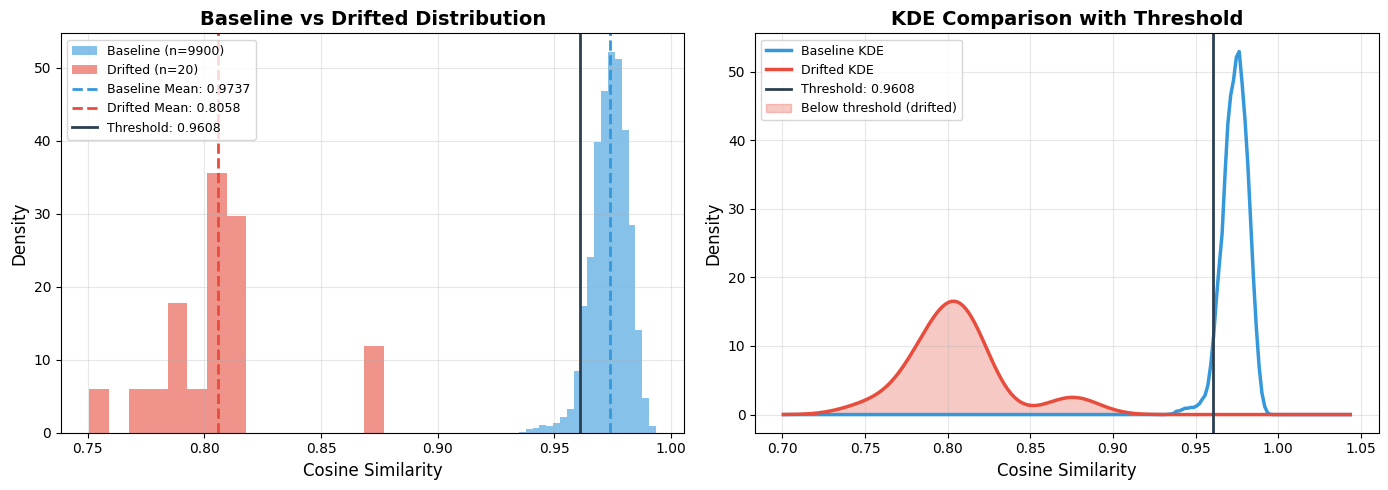


Rejection Rates:
  Baseline: 5.0%
  Drifted:  100.0%


In [108]:
# Visualize baseline vs drifted distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram comparison
ax1 = axes[0]
ax1.hist(baseline_stats["scores"], bins=20, alpha=0.6, color='#3498db', 
         label=f'Baseline (n={len(baseline_stats["scores"])})', density=True)
ax1.hist(drifted_sims, bins=15, alpha=0.6, color='#e74c3c', 
         label=f'Drifted (n={len(drifted_sims)})', density=True)
ax1.axvline(baseline_stats["mean"], color='#3498db', linestyle='--', linewidth=2, 
            label=f'Baseline Mean: {baseline_stats["mean"]:.4f}')
ax1.axvline(np.mean(drifted_sims), color='#e74c3c', linestyle='--', linewidth=2, 
            label=f'Drifted Mean: {np.mean(drifted_sims):.4f}')
ax1.axvline(threshold, color='#2c3e50', linestyle='-', linewidth=2, 
            label=f'Threshold: {threshold:.4f}')
ax1.set_xlabel('Cosine Similarity', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Baseline vs Drifted Distribution', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Right: KDE overlay
ax2 = axes[1]
x_range = np.linspace(min(min(baseline_stats["scores"]), min(drifted_sims)) - 0.05, 
                      max(max(baseline_stats["scores"]), max(drifted_sims)) + 0.05, 200)

kde_baseline = gaussian_kde(baseline_stats["scores"])
kde_drifted = gaussian_kde(drifted_sims)

ax2.plot(x_range, kde_baseline(x_range), color='#3498db', linewidth=2.5, label='Baseline KDE')
ax2.plot(x_range, kde_drifted(x_range), color='#e74c3c', linewidth=2.5, label='Drifted KDE')
ax2.axvline(threshold, color='#2c3e50', linestyle='-', linewidth=2, label=f'Threshold: {threshold:.4f}')

# Shade area below threshold for drifted distribution
x_fill = x_range[x_range < threshold]
ax2.fill_between(x_fill, kde_drifted(x_fill), alpha=0.3, color='#e74c3c', 
                 label='Below threshold (drifted)')

ax2.set_xlabel('Cosine Similarity', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('KDE Comparison with Threshold', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate rejection rate
baseline_rejection_rate = np.mean(baseline_stats["scores"] < threshold) * 100
drifted_rejection_rate = np.mean(drifted_sims < threshold) * 100

print(f"\nRejection Rates:")
print(f"  Baseline: {baseline_rejection_rate:.1f}%")
print(f"  Drifted:  {drifted_rejection_rate:.1f}%")

## Step 13: Recalibration Strategy

Guidelines for when and how to recalibrate the threshold.

In [109]:
# Recalibration Strategy Documentation
recalibration_strategy = """
RECALIBRATION STRATEGY
======================

When to Recalibrate:
-------------------
1. Model version changes (OpenAI updates gpt-4o-mini)
2. System prompt changes materially
3. Embedding model changes (CRITICAL - thresholds become invalid!)
4. Drift detection triggers consistently
5. Observed acceptance/rejection rates shift significantly
6. Periodic schedule (e.g., monthly for production systems)

Dataset Split Strategy:
----------------------
When collecting new calibration data:
- Calibration Set (60-70%): Used to compute threshold
- Validation Set (20-30%): Used to verify threshold performance  
- Holdout Set (10%): Never touched during calibration, used for final audit

Important Notes:
---------------
- Do NOT use the same data for both drift detection and recalibration
- Keep audit samples untouched to avoid overfitting
- Log all calibration runs with timestamps for traceability
- Store reference embeddings separately for version control
"""

print(recalibration_strategy)


RECALIBRATION STRATEGY

When to Recalibrate:
-------------------
1. Model version changes (OpenAI updates gpt-4o-mini)
2. System prompt changes materially
3. Embedding model changes (CRITICAL - thresholds become invalid!)
4. Drift detection triggers consistently
5. Observed acceptance/rejection rates shift significantly
6. Periodic schedule (e.g., monthly for production systems)

Dataset Split Strategy:
----------------------
When collecting new calibration data:
- Calibration Set (60-70%): Used to compute threshold
- Validation Set (20-30%): Used to verify threshold performance  
- Holdout Set (10%): Never touched during calibration, used for final audit

Important Notes:
---------------
- Do NOT use the same data for both drift detection and recalibration
- Keep audit samples untouched to avoid overfitting
- Log all calibration runs with timestamps for traceability
- Store reference embeddings separately for version control



## Step 14: Export Calibration Results

Save calibration results for production use.

In [ ]:
# Create calibration results dictionary
calibration_results = {
    "metadata": {
        "calibration_date": datetime.now().isoformat(),
        "experiment_id": EXPERIMENT_ID,
        "n_samples": len(outputs),
        "generation_model": GENERATION_MODEL,
        "embedding_model": EMBEDDING_MODEL,
        "temperature": SELECTED_TEMPERATURE,
        "multi_temp_mode": MULTI_TEMP_MODE
    },
    "threshold": {
        "value": float(threshold),
        "percentile": THRESHOLD_PERCENTILE,
        "ci_low": float(ci_low),
        "ci_high": float(ci_high),
        "confidence_level": CONFIDENCE_LEVEL
    },
    "baseline_statistics": {
        "mean": float(baseline_stats["mean"]),
        "std": float(baseline_stats["std"]),
        "min": float(np.min(baseline_stats["scores"])),
        "max": float(np.max(baseline_stats["scores"]))
    },
    "drift_detection_config": {
        "window_size": DRIFT_WINDOW_SIZE,
        "ks_alpha": DRIFT_ALPHA,
        "z_threshold": DRIFT_Z_THRESHOLD
    }
}

# Display results
print("CALIBRATION RESULTS")
print("=" * 60)
print(json.dumps(calibration_results, indent=2))
print("=" * 60)


CALIBRATION RESULTS
{
  "metadata": {
    "calibration_date": "2026-01-23T00:30:08.817494",
    "n_samples": 100,
    "generation_model": "gpt-4o-mini",
    "embedding_model": "text-embedding-3-small",
    "temperature": 0.2
  },
  "threshold": {
    "value": 0.9607922426622433,
    "percentile": 5,
    "ci_low": 0.9604722465026719,
    "ci_high": 0.9611988946221208,
    "confidence_level": 0.95
  },
  "baseline_statistics": {
    "mean": 0.9737073871217972,
    "std": 0.007806619195791746,
    "min": 0.9347537885169127,
    "max": 0.9935654319645777
  },
  "drift_detection_config": {
    "window_size": 50,
    "ks_alpha": 0.05,
    "z_threshold": 2
  }
}


## Summary and Next Steps

Final summary of calibration results and operational recommendations.

In [ ]:
print("""
================================================================================
                      CALIBRATION SUMMARY
================================================================================
""")

print(f"EXPERIMENT")
print(f"  ID:               {EXPERIMENT_ID}")
print(f"  Temperature:      {SELECTED_TEMPERATURE}")
print(f"  Multi-temp mode:  {MULTI_TEMP_MODE}")
print()

print(f"CALIBRATED THRESHOLD")
print(f"  Value:            {threshold:.4f}")
print(f"  95% CI:           [{ci_low:.4f}, {ci_high:.4f}]")
print(f"  Percentile:       {THRESHOLD_PERCENTILE}th")
print()

print(f"BASELINE DISTRIBUTION")
print(f"  Mean:             {baseline_stats['mean']:.4f}")
print(f"  Std:              {baseline_stats['std']:.4f}")
print(f"  N samples:        {len(baseline_stats['scores'])}")
print()

print(f"OPERATIONAL POLICY")
print(f"  IF score >= {threshold:.4f}  --> ACCEPT")
print(f"  IF score <  {threshold:.4f}  --> RETRY (up to 3 times)")
print(f"  IF still below threshold  --> ESCALATE")
print()

print(f"DRIFT MONITORING")
print(f"  Window size:      {DRIFT_WINDOW_SIZE} samples")
print(f"  KS test alpha:    {DRIFT_ALPHA}")
print(f"  Mean shift z:     {DRIFT_Z_THRESHOLD}")
print()

print("""
NEXT STEPS:
-----------
1. Integrate threshold into production runtime
2. Implement drift monitoring pipeline
3. Set up alerting for drift detection
4. Schedule periodic recalibration (e.g., monthly)
5. Track acceptance/rejection rates over time
6. Compare thresholds across different temperatures

IMPORTANT CAVEATS:
-----------------
- Cosine similarity alone won't catch format/structure violations
- Add hard validators for JSON schema, required fields, etc.
- Self-consistency != correctness (you can be consistently wrong)
- Recalibrate when embedding model changes (thresholds invalidated!)
- Higher temperatures may require different thresholds
================================================================================
""")


                      CALIBRATION SUMMARY

CALIBRATED THRESHOLD
  Value:            0.9608
  95% CI:           [0.9605, 0.9612]
  Percentile:       5th

BASELINE DISTRIBUTION
  Mean:             0.9737
  Std:              0.0078
  N samples:        9900

OPERATIONAL POLICY
  IF score >= 0.9608  --> ACCEPT
  IF score <  0.9608  --> RETRY (up to 3 times)
  IF still below threshold  --> ESCALATE

DRIFT MONITORING
  Window size:      50 samples
  KS test alpha:    0.05
  Mean shift z:     2


NEXT STEPS:
-----------
1. Integrate threshold into production runtime
2. Implement drift monitoring pipeline
3. Set up alerting for drift detection
4. Schedule periodic recalibration (e.g., monthly)
5. Track acceptance/rejection rates over time

IMPORTANT CAVEATS:
-----------------
- Cosine similarity alone won't catch format/structure violations
- Add hard validators for JSON schema, required fields, etc.
- Self-consistency != correctness (you can be consistently wrong)
- Recalibrate when embedding